In [31]:
import torch
import torch.nn as nn
from torch_geometric.data import Data, Dataset
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GCNConv
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score

In [32]:
import tifffile
import matplotlib.pyplot as plt
from skimage.measure import find_contours
from skimage.draw import polygon
from matplotlib.collections import LineCollection
import pandas as pd
import numpy as np
from scipy.spatial.distance import euclidean

In [33]:
folder = 'DUMM_giTG69_Glucose_013025'
all_cells_filename = f'/Users/noravivancogonzalez/Documents/DuMM_image_analysis/all_cell_data_{folder}.pkl'
all_cells_pd = pd.read_pickle(all_cells_filename)

In [34]:
FOV = '007'
trench_id = '295'
df = all_cells_pd[(all_cells_pd['FOV'] == FOV) & (all_cells_pd['trench_id'] == trench_id)].copy()

In [35]:
df['track_id'] = df['track_id'].astype(int).astype(str)

In [36]:
#for fov 007 and trench id 295
# manually correcting lineages id from track id
ground_truth_lineage_id_dict = {'7': 'A',
                                '25':'A.1',
                                '46':'A.1',
                                '67':'A.1',
                                '73':'A.1.1',
                                '79':'A.1.1',
                                '97':'A.1.1',
                                '102':'A.1.1',
                                '108':'A.1.1',
                                '115':'A.1.1',
                                '119':'A.1.1',
                                '124':'A.1.1',
                                '130':'A.1.1',
                                '132':'A.1.1',
                                '135':'A.1.1',
                                '140':'A.1.1',
                                '142':'A.1.1',
                                '143':'A.1.1.1',
                                '151':'A.1.1.1',
                                '154':'A.1.1.1',
                                '159':'A.1.1.1',
                                '163':'A.1.1.1',
                                '167':'A.1.1.1',
                                '172':'A.1.1.1',
                                '178':'A.1.1.1',
                                '183':'A.1.1.1',
                                '144':'A.1.1.2',
                                '152':'A.1.1.2',
                                '155':'A.1.1.2',
                                '160':'A.1.1.2',
                                '164':'A.1.1.2',
                                '168':'A.1.1.2',
                                '173':'A.1.1.2',
                                '179':'A.1.1.2',
                                '184':'A.1.1.2',
                                '187':'A.1.1.2',
                                '191':'A.1.1.2',
                                '196':'A.1.1.2',
                                '202':'A.1.1.2',
                                '74':'A.1.2',
                                '80':'A.1.2',
                                '93':'A.1.2',
                                '109':'A.1.2',
                                '120':'A.1.2',
                                '125':'A.1.2',
                                '131':'A.1.2',
                                '133':'A.1.2',
                                '136':'A.1.2',
                                '141':'A.1.2',
                                '145':'A.1.2.1',
                                '150':'A.1.2.1',
                                '156':'A.1.2.1',
                                '161':'A.1.2.1',
                                '169':'A.1.2.1',
                                '174':'A.1.2.1',
                                '180':'A.1.2.1',
                                '188':'A.1.2.1',
                                '192':'A.1.2.1',
                                '197':'A.1.2.1',
                                '203':'A.1.2.1',
                                '208':'A.1.2.1',
                                '213':'A.1.2.1',
                                '146':'A.1.2.2',
                                '162':'A.1.2.2',
                                '165':'A.1.2.2',
                                '170':'A.1.2.2',
                                '175':'A.1.2.2',
                                '181':'A.1.2.2',
                                '193':'A.1.2.2',
                                '198':'A.1.2.2',
                                '204':'A.1.2.2',
                                '209':'A.1.2.2',
                                '216':'A.1.2.2',
                                '222':'A.1.2.2',
                                '74':'A.1.2',
                                '19': 'A.2',
                                '81': 'A.2.1',
                                '88':'A.2.1',
                                '94':'A.2.1',
                                '137':'A.2.1',
                                '147':'A.2.1.1',
                                '166':'A.2.1.1',
                                '176':'A.2.1.1',
                                '182':'A.2.1.1',
                                '189':'A.2.1.1',
                                '194':'A.2.1.1',
                                '199':'A.2.1.1',
                                '205':'A.2.1.1',
                                '210':'A.2.1.1',
                                '217':'A.2.1.1',
                                '223':'A.2.1.1',
                                '229':'A.2.1.1',
                                '234':'A.2.1.1',
                                '148':'A.2.1.2',
                                '157':'A.2.1.2',
                                '177':'A.2.1.2',
                                '195':'A.2.1.2',
                                '206':'A.2.1.2',
                                '211':'A.2.1.2',
                                '214':'A.2.1.2',
                                '218':'A.2.1.2',
                                '224':'A.2.1.2.1',
                                '230':'A.2.1.2.1',
                                '235':'A.2.1.2.1',
                                '240':'A.2.1.2.1',
                                '245':'A.2.1.2.1',
                                '249':'A.2.1.2.1',
                                '225':'A.2.1.2.2',
                                '82': 'A.2.2',
                                '138':'A.2.2.1',
                                '158':'A.2.2.1',
                                '171':'A.2.2.1',
                                '190':'A.2.2.1',
                                '207':'A.2.2.1',
                                '212':'A.2.2.1',
                                '220':'A.2.2.1',
                                '227':'A.2.2.1',
                                '232':'A.2.2.1',
                                '238':'A.2.2.1',
                                '243':'A.2.2.1',
                                '247':'A.2.2.1',
                                '255':'A.2.2.1',
                                '258':'A.2.2.1',
                                '262':'A.2.2.1',
                                '264':'A.2.2.1',
                                '267':'A.2.2.1.1',
                                '268':'A.2.2.1.2',
                                '139':'A.2.2.2',
                                '200': 'A.2.2.2.1',
                                '215': 'A.2.2.2.1',
                                '221': 'A.2.2.2.1',
                                '228': 'A.2.2.2.1',
                                '233': 'A.2.2.2.1',
                                '239': 'A.2.2.2.1',
                                '244': 'A.2.2.2.1',
                                '248': 'A.2.2.2.1',
                                '252': 'A.2.2.2.1',
                                '256': 'A.2.2.2.1',
                                '259': 'A.2.2.2.1',
                                '263': 'A.2.2.2.1',
                                '265': 'A.2.2.2.1',
                                '266': 'A.2.2.2.1',
                                '269': 'A.2.2.2.1',
                                '272': 'A.2.2.2.1',
                                '274': 'A.2.2.2.1',
                                '201': 'A.2.2.2.2',
                                '273': 'A.2.2.2.2',
                                '277': 'A.2.2.2.2',
                                '278': 'A.2.2.2.2.1',
                                '280': 'A.2.2.2.2.1',
                                '281': 'A.2.2.2.2.1',
                                '282': 'A.2.2.2.2.1',
                                '283': 'A.2.2.2.2.1',
                                '284': 'A.2.2.2.2.1',
                                '285': 'A.2.2.2.2.1',
                                '286': 'A.2.2.2.2.1',
                                '287': 'A.2.2.2.2.1.1',
                                '288': 'A.2.2.2.2.1.2',
                                '279': 'A.2.2.2.2.2',
                                '289': 'A.2.2.2.2.1',
                                '291': 'A.2.2.2.2.1',
                                '292': 'A.2.2.2.2.1',
                                '293': 'A.2.2.2.2.1',
                                '294': 'A.2.2.2.2.1',
                                '295': 'A.2.2.2.2.1',
                                '296': 'A.2.2.2.2.1',
                                '297': 'A.2.2.2.2.1',
                                '298': 'A.2.2.2.2.1',
                                '290': 'A.2.2.2.2.2.2',
                                '299': 'A.2.2.2.2.2.2',
                                '300': 'A.2.2.2.2.2.2',
                                '301': 'A.2.2.2.2.2.2',
                                '302': 'A.2.2.2.2.2.2.1',
                                '304': 'A.2.2.2.2.2.2.1',
                                '305': 'A.2.2.2.2.2.2.1',
                                '306': 'A.2.2.2.2.2.2.1',
                                '307': 'A.2.2.2.2.2.2.1',
                                '308': 'A.2.2.2.2.2.2.1',
                                '309': 'A.2.2.2.2.2.2.1',
                                '303': 'A.2.2.2.2.2.2.2',
                                '310': 'A.2.2.2.2.2.2.2',
                                '311': 'A.2.2.2.2.2.2.2',
                                '312': 'A.2.2.2.2.2.2.2',
                                '313': 'A.2.2.2.2.2.2.2.1',
                                '315': 'A.2.2.2.2.2.2.2.1',
                                '316': 'A.2.2.2.2.2.2.2.1',
                                '317': 'A.2.2.2.2.2.2.2.1',
                                '318': 'A.2.2.2.2.2.2.2.1',
                                '319': 'A.2.2.2.2.2.2.2.1',
                                '320': 'A.2.2.2.2.2.2.2.1',
                                '314': 'A.2.2.2.2.2.2.2.2',
                                '321': 'A.2.2.2.2.2.2.2.2',
                                '322': 'A.2.2.2.2.2.2.2.2',
                                '323': 'A.2.2.2.2.2.2.2.2',
                                '324': 'A.2.2.2.2.2.2.2.2',
                                '325': 'A.2.2.2.2.2.2.2.2',
                                '326': 'A.2.2.2.2.2.2.2.2',
                                '327': 'A.2.2.2.2.2.2.2.2.1',
                                '329': 'A.2.2.2.2.2.2.2.2.1',
                                '330': 'A.2.2.2.2.2.2.2.2.1',
                                '328': 'A.2.2.2.2.2.2.2.2.2',
                                '331': 'A.2.2.2.2.2.2.2.2.2',
                                '332': 'A.2.2.2.2.2.2.2.2.2.1',
                                '333': 'A.2.2.2.2.2.2.2.2.2.2'}

In [37]:
df['ground_truth_lineage'] = None
df['ground_truth_lineage']= df['track_id'].map(ground_truth_lineage_id_dict)

In [38]:
df.rename(columns = {'centroid-0': 'centroid_y','centroid-1': 'centroid_x'}, inplace = True)

In [39]:
df_cells = df[df['ground_truth_lineage'].notna()]

In [40]:
df_cells.shape

(359, 19)

In [41]:
df_cells.columns

Index(['label', 'area', 'coords', 'centroid_y', 'centroid_x',
       'axis_major_length', 'axis_minor_length', 'intensity_mean_phase',
       'intensity_max_phase', 'intensity_min_phase', 'intensity_mean_fluor',
       'intensity_max_fluor', 'intensity_min_fluor', 'time_frame',
       'experiment_name', 'FOV', 'trench_id', 'track_id',
       'ground_truth_lineage'],
      dtype='object')

In [42]:
# Define node features
node_feature_cols = ['area', 'centroid_y', 
       'axis_major_length', 'axis_minor_length', 'intensity_mean_phase',
       'intensity_max_phase', 'intensity_min_phase', 'intensity_mean_fluor',
       'intensity_max_fluor', 'intensity_min_fluor']

for col in node_feature_cols:
    df_cells[col] = df_cells[col].astype(np.float32);               

/var/folders/hj/bk95lprn3zb88y7bqhjh9j5m0000gr/T/ipykernel_84787/1998573771.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cells[col] = df_cells[col].astype(np.float32);
/var/folders/hj/bk95lprn3zb88y7bqhjh9j5m0000gr/T/ipykernel_84787/1998573771.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cells[col] = df_cells[col].astype(np.float32);
/var/folders/hj/bk95lprn3zb88y7bqhjh9j5m0000gr/T/ipykernel_84787/1998573771.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

In [43]:
# Convert lineage IDs to unique integers as labels
all_unique_lineages = sorted(df_cells['ground_truth_lineage'].unique())
lineage_to_int_mapping = {lineage: i for i, lineage in enumerate(all_unique_lineages)}
num_lineage_classes = len(all_unique_lineages)

In [44]:
df_cells['numeric_lineage'] = df_cells['ground_truth_lineage'].map(lineage_to_int_mapping)

/var/folders/hj/bk95lprn3zb88y7bqhjh9j5m0000gr/T/ipykernel_84787/1883193674.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cells['numeric_lineage'] = df_cells['ground_truth_lineage'].map(lineage_to_int_mapping)


In [67]:
def identify_sub_lineage_roots(df):
    # Ensure relevant columns are present
    required_cols = ['experiment_name', 'FOV', 'trench_id', 'ground_truth_lineage', 'time_frame', 'node_id']
    if not all(col in df.columns for col in required_cols):
        raise ValueError(f"DataFrame must contain all required columns: {required_cols}")
    df_temp_sorted = df.sort_values(by=['time_frame', 'node_id'])
    first_appearances = df_temp_sorted.drop_duplicates(
        subset=['experiment_name', 'FOV', 'trench_id', 'ground_truth_lineage'],
        keep='first'
    )

    # Extract the necessary information for each root
    # Convert to list of tuples as in the original function's output format
    sub_lineage_roots = list(first_appearances[[
        'experiment_name',
        'FOV',
        'trench_id',
        'ground_truth_lineage',
        'time_frame'
    ]].itertuples(index=False, name=None))

    return sub_lineage_roots

In [68]:
df_cells['node_id'] = df_cells.index # Assign unique global node ID

/var/folders/hj/bk95lprn3zb88y7bqhjh9j5m0000gr/T/ipykernel_84787/157364811.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cells['node_id'] = df_cells.index # Assign unique global node ID


In [69]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

In [74]:
# The function expects a sub-DataFrame already filtered for a specific lineage branch
def create_lineage_graph(df_lineage, device='cpu'):
    original_global_node_ids = df_lineage['node_id'].values
    global_id_to_local_idx = {global_id: i for i, global_id in enumerate(original_global_node_ids)}

    x = torch.tensor(df_lineage[node_feature_cols].values, dtype=torch.float).to(device)
    y = torch.tensor(df_lineage['numeric_lineage'].values, dtype=torch.long).to(device)
    pos = torch.tensor(df_lineage['centroid_y'].values, dtype=torch.float).to(device)
    node_time_frames = torch.tensor(df_lineage['time_frame'].values, dtype=torch.long).to(device)


    num_nodes = len(df_lineage)
    if num_nodes == 0:
        return None

    source_nodes_local_idx = []
    target_nodes_local_idx = []

    sorted_time_frames = sorted(df_lineage['time_frame'].unique())

    for i in range(len(sorted_time_frames) - 1):
        current_t = sorted_time_frames[i]
        next_t = sorted_time_frames[i+1]

        df_current_t = df_lineage[df_lineage['time_frame'] == current_t]
        df_next_t = df_lineage[df_lineage['time_frame'] == next_t]

        current_lineage_to_node = df_current_t.set_index('ground_truth_lineage')['node_id'].to_dict()
        next_lineage_to_node = df_next_t.set_index('ground_truth_lineage')['node_id'].to_dict()

        for idx, row in df_current_t.iterrows():
            current_global_node_id = row['node_id']
            current_ground_truth_lineage = row['ground_truth_lineage']

            if current_ground_truth_lineage in next_lineage_to_node:
                next_global_node_id = next_lineage_to_node[current_ground_truth_lineage]
                source_nodes_local_idx.append(global_id_to_local_idx[current_global_node_id])
                target_nodes_local_idx.append(global_id_to_local_idx[next_global_node_id])

            daughter1_lineage = f"{current_ground_truth_lineage}.1"
            daughter2_lineage = f"{current_ground_truth_lineage}.2"

            if daughter1_lineage in next_lineage_to_node:
                next_global_node_id = next_lineage_to_node[daughter1_lineage]
                source_nodes_local_idx.append(global_id_to_local_idx[current_global_node_id])
                target_nodes_local_idx.append(global_id_to_local_idx[next_global_node_id])
            if daughter2_lineage in next_lineage_to_node:
                next_global_node_id = next_lineage_to_node[daughter2_lineage]
                source_nodes_local_idx.append(global_id_to_local_idx[current_global_node_id])
                target_nodes_local_idx.append(global_id_to_local_idx[next_global_node_id])

    if not source_nodes_local_idx:
        edge_index = torch.empty((2, 0), dtype=torch.long).to(device)
    else:
        unique_edges = list(set(zip(source_nodes_local_idx, target_nodes_local_idx)))
        source_nodes_unique, target_nodes_unique = zip(*unique_edges)
        edge_index = torch.tensor([list(source_nodes_unique), list(target_nodes_unique)], dtype=torch.long).to(device)

    data = Data(x=x,
                edge_index=edge_index,
                y=y,
                pos=pos,
                num_nodes=num_nodes,
                time_frame=node_time_frames,
                original_global_node_ids=torch.tensor(original_global_node_ids, dtype=torch.long),
                root_lineage_branch=df_lineage['ground_truth_lineage'].iloc[0], # The GTL that defines this subgraph
                start_time_frame=df_lineage['time_frame'].min(),
                experiment_name=df_lineage['experiment_name'].iloc[0],
                fov=df_lineage['FOV'].iloc[0],
                trench_id=df_lineage['trench_id'].iloc[0]
               )
    return data

In [71]:
sub_lineage_roots_tuples = identify_sub_lineage_roots(df_cells)
branch_graphs_list = []

In [72]:
for exp, fov, trench, root_lineage_str, start_t in sub_lineage_roots_tuples:
    # Filter the DataFrame to include only the cells belonging to this specific sub-lineage branch
    # and starting from its first appearance time
    df_branch = df_cells[
        (df_cells['experiment_name'] == exp) &
        (df_cells['FOV'] == fov) &
        (df_cells['trench_id'] == trench) &
        (df_cells['time_frame'] >= start_t) &
        # This regex ensures we only get descendants of this specific root_lineage_str
        (df_cells['ground_truth_lineage'].apply(lambda x: x == root_lineage_str or x.startswith(f"{root_lineage_str}.")))
    ].copy() # Use .copy() to avoid SettingWithCopyWarning

    # Ensure the branch actually has cells, otherwise skip
    if not df_branch.empty:
        #print(f"Processing Sub-Lineage: '{root_lineage_str}' starting at t={start_t} (Exp: {exp}, FOV: {fov}, Trench: {trench})...")
        graph = create_lineage_graph(df_branch, device=device)
        if graph is not None:
            branch_graphs_list.append(graph)
        else:
            print(f"  Skipped (no valid connections/nodes) for '{root_lineage_str}' at t={start_t}")
    else:
        print(f"  Skipped (empty DataFrame) for '{root_lineage_str}' at t={start_t}")


print(f"\nSuccessfully created {len(branch_graphs_list)} PyG graphs, one per identified sub-lineage branch.")



Successfully created 34 PyG graphs, one per identified sub-lineage branch.


In [73]:
if branch_graphs_list:
    print("\nExample Sub-Lineage Graph Details:")
    for i, graph in enumerate(branch_graphs_list[:3]): # Print details for first 3 graphs
        print(f"\n--- Graph {i+1} ---")
        print(graph)
        print(f"  Nodes (x.shape): {graph.x.shape}")
        print(f"  Edges (edge_index.shape): {graph.edge_index.shape}")
        print(f"  Labels (y.shape): {graph.y.shape}")
        print(f"  Root Lineage Branch ID: {graph.root_lineage_branch}")
        print(f"  Start Time Frame: {graph.start_time_frame}")
        print(f"  Experiment Name: {graph.experiment_name}")
        print(f"  FOV: {graph.fov}")
        print(f"  Trench ID: {graph.trench_id}")
        # Optionally, print the actual ground truth lineage IDs in this subgraph for verification
        # print(f"  Included Lineages: {df_cells.loc[graph.node_id.cpu().numpy()]['ground_truth_lineage'].unique()}")


Example Sub-Lineage Graph Details:

--- Graph 1 ---
Data(x=[359, 10], edge_index=[2, 342], y=[359], pos=[359], num_nodes=359, time_frame=[359], original_global_node_ids=[359], root_lineage_branch='A.1.1.2', start_time_frame=0, experiment_name='DUMM_giTG69_Glucose_013025', fov='007', trench_id='295')
  Nodes (x.shape): torch.Size([359, 10])
  Edges (edge_index.shape): torch.Size([2, 342])
  Labels (y.shape): torch.Size([359])
  Root Lineage Branch ID: A.1.1.2
  Start Time Frame: 0
  Experiment Name: DUMM_giTG69_Glucose_013025
  FOV: 007
  Trench ID: 295

--- Graph 2 ---
Data(x=[267, 10], edge_index=[2, 259], y=[267], pos=[267], num_nodes=267, time_frame=[267], original_global_node_ids=[267], root_lineage_branch='A.2.1.2.1', start_time_frame=1, experiment_name='DUMM_giTG69_Glucose_013025', fov='007', trench_id='295')
  Nodes (x.shape): torch.Size([267, 10])
  Edges (edge_index.shape): torch.Size([2, 259])
  Labels (y.shape): torch.Size([267])
  Root Lineage Branch ID: A.2.1.2.1
  Start 

In [22]:
# Define split ratios
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15 

# Ensure ratios sum to 1
assert abs(train_ratio + val_ratio + test_ratio - 1.0) < 1e-6, "Ratios must sum to 1."

# Sequentially split data because train_test_split can only split into 2 sets
train_graphs, temp_graphs = train_test_split(
    branch_graphs_list,
    test_size=(val_ratio + test_ratio), # Combined size for validation and test
    random_state=0 # set seed for reproducibility
)

# split temp_graphs into validation and test sets
# (test_ratio / (val_ratio + test_ratio)) ensures the correct proportion from the temporary set
val_graphs, test_graphs = train_test_split(
    temp_graphs,
    test_size=(test_ratio / (val_ratio + test_ratio)),
    random_state=0 # set seed for reproducibility
)

print(f"Total number of graphs: {len(branch_graphs_list)}")
print(f"Number of training graphs: {len(train_graphs)}")
print(f"Number of validation graphs: {len(val_graphs)}")
print(f"Number of test graphs: {len(test_graphs)}")

Total number of graphs: 34
Number of training graphs: 23
Number of validation graphs: 5
Number of test graphs: 6


In [75]:
# Lineage dataset
class LineageDataset(Dataset):
    def __init__(self, data_list):
        super().__init__()
        self.data_list = data_list

    def len(self):
        return len(self.data_list)

    def get(self, idx):
        return self.data_list[idx]

In [76]:
from torch_geometric.loader import DataLoader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

In [25]:
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool
from torch_geometric.utils import add_self_loops, negative_sampling

In [26]:
class LineageLinkPredictionGNN(nn.Module):
    def __init__(self, in_channels, hidden_channels):
        super(LineageLinkPredictionGNN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels) 
        self.conv2 = GCNConv(hidden_channels, hidden_channels) # Output node embeddings

        # Decoder/multilayer perceptron for link prediction:
        self.decoder = nn.Sequential(
            nn.Linear(2 * hidden_channels, 64),
            nn.ReLU(),
            nn.Linear(64, 1) # Output a single logit for binary classification
        )

    def forward(self, x, edge_index):
        # GNN Encoder
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index) # x are now node embeddings

        return x # Return node embeddings
    
    def decode(self, z, pos_edge_index, neg_edge_index=None):
        # z: node embeddings from forward()
        # pos_edge_index: actual edges in the batch
        # neg_edge_index: sampled negative edges in the batch

        edge_indices = torch.cat([pos_edge_index, neg_edge_index], dim=-1) if neg_edge_index is not None else pos_edge_index

        # Concatenate embeddings of source and target nodes for each edge
        source_embed = z[edge_indices[0]]
        target_embed = z[edge_indices[1]]
        edge_features = torch.cat([source_embed, target_embed], dim=-1) # Concatenate

        # Pass through decoder to get logits
        logits = self.decoder(edge_features).squeeze(-1) # Squeeze to get [num_edges]
        return logits


# Model and Optimizer setup

In [77]:
class LineageLinkPredictionGNN(nn.Module):
    def __init__(self, in_channels, hidden_channels):
        super(LineageLinkPredictionGNN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)

        # Decoder/multilayer perceptron for link prediction:
        self.decoder = nn.Sequential(
            nn.Linear(2 * hidden_channels, 64),
            nn.ReLU(),
            nn.Linear(64, 1) # Output a single logit for binary classification
        )

    def forward(self, x, edge_index):
        # GNN Encoder
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index) # x are now node embeddings

        return x # Return node embeddings

    def decode(self, z, edge_index, neg_edge_index=None): # Renamed pos_edge_index to edge_index for clarity
        # z: node embeddings from forward()
        # edge_index: actual edges in the batch (positive samples)
        # neg_edge_index: sampled negative edges in the batch

        all_edge_indices = torch.cat([edge_index, neg_edge_index], dim=-1) if neg_edge_index is not None else edge_index

        # Concatenate embeddings of source and target nodes for each edge
        source_embed = z[all_edge_indices[0]]
        target_embed = z[all_edge_indices[1]]
        edge_features = torch.cat([source_embed, target_embed], dim=-1) # Concatenate

        # Pass through decoder to get logits
        logits = self.decoder(edge_features).squeeze(-1) # Squeeze to get [num_edges]
        return logits


In [78]:
def generate_local_temporal_negative_samples(data: Data, num_neg_samples_per_pos_edge: float, radius_threshold: float, device='cpu'):
    """
    Generates negative samples by considering only cells in consecutive time frames
    and within a certain spatial radius of potential source nodes, excluding true positives.

    Args:
        data (torch_geometric.data.Data): A single graph batch containing x, edge_index, pos, time_frame.
        num_neg_samples_per_pos_edge (float): Ratio of negative samples to positive samples.
                                                e.g., 1.0 for 1:1, 2.0 for 2:1.
        radius_threshold (float): Maximum spatial distance for a potential negative connection.
        device (str): Device to put tensors on.

    Returns:
        torch.Tensor: edge_index of sampled negative connections, shape [2, num_neg_samples].
    """
    if data.edge_index.numel() == 0: # No positive edges, no negative samples possible this way
        return torch.empty((2, 0), dtype=torch.long, device=device)

    # Convert tensors to CPU for easier numpy/list processing if needed, then back to device
    pos_coords = data.pos.cpu().numpy() # Assuming pos is [num_nodes, 2] (y,x) or [num_nodes, 1] (y)
    time_frames = data.time_frame.cpu().numpy()
    num_nodes = data.num_nodes
    existing_edges = set(tuple(e) for e in data.edge_index.cpu().T.tolist()) # Convert to set for fast lookup

    potential_neg_samples = []

    # Iterate through all possible source nodes
    for i in range(num_nodes):
        current_node_time = time_frames[i]
        current_node_pos = pos_coords[i]

        # Iterate through all possible target nodes (j)
        for j in range(num_nodes):
            # 1. Temporal Constraint: Only consider next time frame
            if time_frames[j] != current_node_time + 1:
                continue

            # 2. Local Constraint: Check spatial proximity (Euclidean distance)
            target_node_pos = pos_coords[j]
            # Adjust distance calculation based on your 'pos' dimension
            if pos_coords.ndim == 1: # If 'pos' is just centroid_y (1D)
                distance = np.abs(current_node_pos - target_node_pos)
            else: # If 'pos' is (y, x) or (x, y) etc. (2D or more)
                distance = np.linalg.norm(current_node_pos - target_node_pos)

            if distance > radius_threshold:
                continue

            # 3. Exclude existing positive edges
            if (i, j) not in existing_edges:
                potential_neg_samples.append((i, j))

    # Convert to tensor
    if not potential_neg_samples:
        return torch.empty((2, 0), dtype=torch.long, device=device)

    potential_neg_samples_tensor = torch.tensor(potential_neg_samples, dtype=torch.long).T.to(device)

    # Sample a subset of potential negative samples based on ratio
    num_positive_edges = data.edge_index.size(1)
    desired_neg_samples = int(num_positive_edges * num_neg_samples_per_pos_edge)

    if desired_neg_samples >= potential_neg_samples_tensor.size(1):
        # If not enough potential negatives, take all of them
        return potential_neg_samples_tensor
    else:
        # Randomly sample the desired number of negative edges
        indices = torch.randperm(potential_neg_samples_tensor.size(1), device=device)[:desired_neg_samples]
        return potential_neg_samples_tensor[:, indices]


In [86]:
def train_link_prediction(model, train_loader, optimizer, criterion, device, neg_sample_ratio=1.0, radius_threshold=None):
    model.train()
    total_loss = 0

    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()

        # 1. Generate negative edges
        neg_edge_index = generate_local_temporal_negative_samples(
            data,
            num_neg_samples_per_pos_edge=neg_sample_ratio, # How many neg samples per positive edge
            radius_threshold=radius_threshold, # Spatial threshold (e.g., 50.0 units)
            device=device
        )
        if neg_edge_index.numel() == 0: # Handle cases where no negative samples could be generated
            # Skip this batch or generate purely random ones if desired
            print("Warning: No negative samples generated for a batch. Skipping or using random.")
            # Fallback to random if no local negatives are found in rare cases
            neg_edge_index = torch_geometric.utils.negative_sampling(
                data.edge_index, num_nodes=data.num_nodes, num_neg_samples=data.edge_index.size(1)).to(device)


        # 2. Get node embeddings from GNN encoder
        z = model(data.x, data.edge_index)

        # 3. Decode edges (both positive and negative)
        pos_logits = model.decode(z, data.edge_index) # Logits for true edges
        neg_logits = model.decode(z, neg_edge_index) # Logits for sampled negative edges

        # 4. Create labels: 1 for positive edges, 0 for negative edges
        pos_labels = torch.ones(pos_logits.size(0), device=device)
        neg_labels = torch.zeros(neg_logits.size(0), device=device)

        # 5. Concatenate logits and labels
        logits = torch.cat([pos_logits, neg_logits])
        labels = torch.cat([pos_labels, neg_labels])

        # 6. Calculate loss
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    return avg_loss

In [96]:
def evaluate_link_prediction(model, loader, criterion, device, neg_sample_ratio=1.0, radius_threshold=None, node_lineage_map=None):
    model.eval()
    total_loss = 0
    all_preds_logits = [] # For aggregated metrics (Loss, AUC)
    all_labels_agg = []    # For aggregated metrics (Loss, Acc, AUC)

    all_predicted_labels_individual = [] # Binary 0/1 predictions
    all_probabilities_individual = []    # Probabilities
    all_true_labels_individual = []      # True labels for the specific edges
    all_evaluated_edge_indices_global = [] # Store global IDs of edges


    # Initialize derived_lineage_labels_final here, as it's returned regardless of node_lineage_map
    derived_lineage_labels_final = []

    with torch.no_grad():
        for data in loader: # data is a PyG Batch object
            data = data.to(device)

            # Essential: Check if 'original_global_node_ids' exists on the Data object
            if not hasattr(data, 'original_global_node_ids'):
                raise AttributeError("The 'data' object (batch) does not have 'original_global_node_ids'. "
                                     "Ensure your create_lineage_graph function attaches this attribute "
                                     "to the Data object before putting it into the DataLoader.")
            
            # This tensor holds the original global node IDs for all nodes in the current batch.
            batch_original_global_node_ids = data.original_global_node_ids.cpu().numpy()

            # Generate negative samples for the current batch
            neg_edge_index = generate_local_temporal_negative_samples(
                data,
                num_neg_samples_per_pos_edge=neg_sample_ratio,
                radius_threshold=radius_threshold,
                device=device
            )
            # Fallback if no local temporal negative samples are generated
            if neg_edge_index.numel() == 0:
                neg_edge_index = torch_geometric.utils.negative_sampling(
                    data.edge_index, num_nodes=data.num_nodes, num_neg_samples=data.edge_index.size(1)
                ).to(device)

            # Encode node features
            z = model(data.x, data.edge_index)

            # Decode positive and negative link logits
            pos_logits = model.decode(z, data.edge_index)
            neg_logits = model.decode(z, neg_edge_index)

            # Create true labels for positive and negative samples
            pos_labels = torch.ones(pos_logits.size(0), device=device)
            neg_labels = torch.zeros(neg_logits.size(0), device=device)

            # Concatenate logits and labels for loss calculation and aggregated metrics
            logits = torch.cat([pos_logits, neg_logits])
            labels = torch.cat([pos_labels, neg_labels])
            
            # Combine the edge indices that were actually evaluated in this batch
            # Corrected variable name: current_evaluated_edge_indices_local
            current_evaluated_edge_indices_local = torch.cat([data.edge_index, neg_edge_index], dim=-1)

            # Calculate loss for the current batch
            loss = criterion(logits, labels)
            total_loss += loss.item()

            # Accumulate logits and labels for aggregated metrics (Loss, Accuracy, AUC-ROC)
            all_preds_logits.append(logits.cpu())
            all_labels_agg.append(labels.cpu())

            # Accumulate individual predictions and probabilities
            probabilities = torch.sigmoid(logits)
            predicted_labels = (probabilities > 0.5).long()

            all_predicted_labels_individual.append(predicted_labels.cpu())
            all_probabilities_individual.append(probabilities.cpu())
            all_true_labels_individual.append(labels.cpu())

            # --- Map local indices back to global IDs for the *current batch's* edges ---
            source_global_ids = batch_original_global_node_ids[current_evaluated_edge_indices_local[0].cpu().numpy()]
            target_global_ids = batch_original_global_node_ids[current_evaluated_edge_indices_local[1].cpu().numpy()]
            
            # Create a tensor of global edge indices for the current batch
            current_evaluated_edge_indices_global = torch.tensor(
                [source_global_ids, target_global_ids], dtype=torch.long
            )
            # Accumulate these global edge indices for later concatenation
            all_evaluated_edge_indices_global.append(current_evaluated_edge_indices_global)


    # --- After the loop: Calculate aggregated metrics ---
    avg_loss = total_loss / len(loader)
    all_preds_logits_agg = torch.cat(all_preds_logits)
    all_labels_np_agg = torch.cat(all_labels_agg).numpy()
    all_preds_proba_agg = torch.sigmoid(all_preds_logits_agg).numpy()

    accuracy = accuracy_score(all_labels_np_agg, (all_preds_proba_agg > 0.5).astype(int))
    auc_score = roc_auc_score(all_labels_np_agg, all_preds_proba_agg)

    # --- After the loop: Concatenate all individual results ---
    final_predicted_labels = torch.cat(all_predicted_labels_individual, dim=0)
    final_probabilities = torch.cat(all_probabilities_individual, dim=0)
    final_true_labels = torch.cat(all_true_labels_individual, dim=0)
    final_evaluated_edge_indices_global = torch.cat(all_evaluated_edge_indices_global, dim=1) # dim=1 for [2, num_edges]

    # --- After the loop: Derive lineage labels using the *final* concatenated tensors ---
    if node_lineage_map: # Only proceed if a node_lineage_map was provided
        # Iterate over each edge using its global IDs and its corresponding true label
        for i in range(final_evaluated_edge_indices_global.size(1)):
            src_global_id = final_evaluated_edge_indices_global[0, i].item()
            dst_global_id = final_evaluated_edge_indices_global[1, i].item()
            true_label_for_this_edge = final_true_labels[i].item() # Get the true label for this specific edge

            # Look up lineage for source and destination nodes
            src_lineage = node_lineage_map.get(src_global_id, 'Unknown_Src_Node')
            dst_lineage = node_lineage_map.get(dst_global_id, 'Unknown_Dst_Node')

            # Define your logic for edge lineage based on node lineages and true label
            if src_lineage.startswith('Unknown') or dst_lineage.startswith('Unknown'):
                edge_lineage = 'Unknown_Edge_Lineage'
            elif true_label_for_this_edge == 0: # This is a negative sample
                edge_lineage = f'NEG_({src_lineage}_to_{dst_lineage})'
            else: # This is a positive sample
                edge_lineage = f'POS_({src_lineage}_to_{dst_lineage})'
            
            derived_lineage_labels_final.append(edge_lineage)
    else:
        # If no node_lineage_map is provided, just fill with 'N/A'
        # Ensure derived_lineage_labels_final is appropriately sized if map is None
        if not derived_lineage_labels_final: # Only if it's still empty from initialization
             derived_lineage_labels_final = ['N/A'] * final_evaluated_edge_indices_global.size(1)

    # Return all metrics and individual predictions (now with global IDs and derived lineages)
    print("evaluate_link_prediction: Function about to return results.")
    return (avg_loss, accuracy, auc_score,
            final_predicted_labels, final_probabilities, final_true_labels,
            final_evaluated_edge_indices_global, derived_lineage_labels_final)

In [97]:
# create graphs
sub_lineage_roots_tuples = identify_sub_lineage_roots(df_cells)
branch_graphs_list = []

for exp, fov, trench, root_lineage_str, start_t in sub_lineage_roots_tuples:
    # Filter the DataFrame to include only the cells belonging to this specific sub-lineage branch
    # and starting from its first appearance time
    df_branch = df_cells[
        (df_cells['experiment_name'] == exp) &
        (df_cells['FOV'] == fov) &
        (df_cells['trench_id'] == trench) &
        (df_cells['time_frame'] >= start_t) &
        # This regex ensures we only get descendants of this specific root_lineage_str
        (df_cells['ground_truth_lineage'].apply(lambda x: x == root_lineage_str or x.startswith(f"{root_lineage_str}.")))
    ].copy() # Use .copy() to avoid SettingWithCopyWarning

    # Ensure the branch actually has cells, otherwise skip
    if not df_branch.empty:
        #print(f"Processing Sub-Lineage: '{root_lineage_str}' starting at t={start_t} (Exp: {exp}, FOV: {fov}, Trench: {trench})...")
        graph = create_lineage_graph(df_branch, device=device)
        if graph is not None:
            branch_graphs_list.append(graph)
        else:
            print(f"  Skipped (no valid connections/nodes) for '{root_lineage_str}' at t={start_t}")
    else:
        print(f"  Skipped (empty DataFrame) for '{root_lineage_str}' at t={start_t}")


print(f"\nSuccessfully created {len(branch_graphs_list)} PyG graphs, one per identified sub-lineage branch.")


Successfully created 34 PyG graphs, one per identified sub-lineage branch.


In [98]:
if branch_graphs_list:
    print("\nExample Sub-Lineage Graph Details:")
    for i, graph in enumerate(branch_graphs_list[:3]): # Print details for first 3 graphs
        print(f"\n--- Graph {i+1} ---")
        print(graph)
        print(f"  Nodes (x.shape): {graph.x.shape}")
        print(f"  Edges (edge_index.shape): {graph.edge_index.shape}")
        print(f"  Labels (y.shape): {graph.y.shape}")
        print(f"  Root Lineage Branch ID: {graph.root_lineage_branch}")
        print(f"  Start Time Frame: {graph.start_time_frame}")
        print(f"  Experiment Name: {graph.experiment_name}")
        print(f"  FOV: {graph.fov}")
        print(f"  Trench ID: {graph.trench_id}")
        # Optionally, print the actual ground truth lineage IDs in this subgraph for verification
        # print(f"  Included Lineages: {df_cells.loc[graph.node_id.cpu().numpy()]['ground_truth_lineage'].unique()}")


Example Sub-Lineage Graph Details:

--- Graph 1 ---
Data(x=[359, 10], edge_index=[2, 342], y=[359], pos=[359], num_nodes=359, time_frame=[359], original_global_node_ids=[359], root_lineage_branch='A.1.1.2', start_time_frame=0, experiment_name='DUMM_giTG69_Glucose_013025', fov='007', trench_id='295')
  Nodes (x.shape): torch.Size([359, 10])
  Edges (edge_index.shape): torch.Size([2, 342])
  Labels (y.shape): torch.Size([359])
  Root Lineage Branch ID: A.1.1.2
  Start Time Frame: 0
  Experiment Name: DUMM_giTG69_Glucose_013025
  FOV: 007
  Trench ID: 295

--- Graph 2 ---
Data(x=[267, 10], edge_index=[2, 259], y=[267], pos=[267], num_nodes=267, time_frame=[267], original_global_node_ids=[267], root_lineage_branch='A.2.1.2.1', start_time_frame=1, experiment_name='DUMM_giTG69_Glucose_013025', fov='007', trench_id='295')
  Nodes (x.shape): torch.Size([267, 10])
  Edges (edge_index.shape): torch.Size([2, 259])
  Labels (y.shape): torch.Size([267])
  Root Lineage Branch ID: A.2.1.2.1
  Start 

In [99]:
# Define split ratios
train_ratio = 0.6
val_ratio = 0.2
test_ratio = 0.2

# Ensure ratios sum to 1
assert abs(train_ratio + val_ratio + test_ratio - 1.0) < 1e-6, "Ratios must sum to 1."

# Sequentially split data because train_test_split can only split into 2 sets
train_graphs, temp_graphs = train_test_split(
    branch_graphs_list,
    test_size=(val_ratio + test_ratio), # Combined size for validation and test
    random_state=0 # set seed for reproducibility
)

# split temp_graphs into validation and test sets
# (test_ratio / (val_ratio + test_ratio)) ensures the correct proportion from the temporary set
val_graphs, test_graphs = train_test_split(
    temp_graphs,
    test_size=(test_ratio / (val_ratio + test_ratio)),
    random_state=0 # set seed for reproducibility
)

print(f"Total number of graphs: {len(branch_graphs_list)}")
print(f"Number of training graphs: {len(train_graphs)}")
print(f"Number of validation graphs: {len(val_graphs)}")
print(f"Number of test graphs: {len(test_graphs)}")

Total number of graphs: 34
Number of training graphs: 20
Number of validation graphs: 7
Number of test graphs: 7


In [100]:
train_dataset = LineageDataset(train_graphs)
val_dataset = LineageDataset(val_graphs)
test_dataset = LineageDataset(test_graphs)

print("\nPyG Datasets created:")
print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)


PyG Datasets created:
Train dataset size: 20
Validation dataset size: 7
Test dataset size: 7


In [101]:
# Determine number of node features in dataset
num_node_features = len(node_feature_cols)

my_radius_threshold = 50.0 # From your previous context
hidden_channels = 64 # balance between expressiveness and compute
epochs = 500
learning_rate = 0.0001
best_val_acc = -1.0  # save the model with the highest validation accuracy
best_val_loss = float('inf') # track the lowest validation loss for early stopping
epochs_no_improve = 0  # Counter for epochs without validation loss improvement
patience = 100 # How many epochs to wait for improvement before stopping

# Instantiate the model with the new parameters
model = LineageLinkPredictionGNN(in_channels=num_node_features, hidden_channels=hidden_channels).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.BCEWithLogitsLoss() # Use BCEWithLogitsLoss for raw logits (no sigmoid needed)

In [102]:
train_losses = []
val_losses = []
val_accuracies = []
val_aucs = []

print("\nStarting link prediction training...")
for epoch in range(1, epochs + 1):
    train_loss = train_link_prediction(model, train_loader, optimizer, criterion, device, neg_sample_ratio=1.0, radius_threshold=my_radius_threshold)
    val_loss, val_acc, val_auc, val_predicted_labels, val_probabilities, val_true_labels, val_evaluated_edge_indices_global, val_derived_lineage_labels = evaluate_link_prediction(
    model, val_loader, criterion, device,
    neg_sample_ratio=1.0, radius_threshold=my_radius_threshold
    )
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    val_aucs.append(val_auc)

    print(f'Epoch: {epoch:03d}, '
          f'Train Loss: {train_loss:.4f}, '
          f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')
    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'best_link_prediction_model.pt')
        print(f"  --> New best validation accuracy. Model saved.")
    # early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve == patience: # patience is another hyperparameter you'd define
            print(f"Early stopping at epoch {epoch} due to no improvement in validation loss.")
            break

print("\nTraining complete!")


Starting link prediction training...
evaluate_link_prediction: Function about to return results.
Epoch: 001, Train Loss: 259.4401, Val Loss: 395.1138, Val Acc: 0.1584
  --> New best validation accuracy. Model saved.
evaluate_link_prediction: Function about to return results.
Epoch: 002, Train Loss: 235.5280, Val Loss: 345.8748, Val Acc: 0.1584
evaluate_link_prediction: Function about to return results.
Epoch: 003, Train Loss: 214.5483, Val Loss: 296.8544, Val Acc: 0.1535
evaluate_link_prediction: Function about to return results.
Epoch: 004, Train Loss: 188.9819, Val Loss: 248.3382, Val Acc: 0.1535
evaluate_link_prediction: Function about to return results.
Epoch: 005, Train Loss: 168.7306, Val Loss: 200.2660, Val Acc: 0.1535
evaluate_link_prediction: Function about to return results.
Epoch: 006, Train Loss: 157.3335, Val Loss: 153.3762, Val Acc: 0.1535
evaluate_link_prediction: Function about to return results.
Epoch: 007, Train Loss: 134.0839, Val Loss: 109.0893, Val Acc: 0.1733
  -

In [111]:
# Create a dictionary connecting node_id to lineage, index = node_id aka node_lineage_map

node_lineage_dict = df_cells['ground_truth_lineage'].to_dict()

Loaded best model for final test evaluation.

 Evaluating on Test Set
evaluate_link_prediction: Function about to return results.
Final Test Results: Loss: 50.4975, Accuracy: 0.5191, AUC-ROC: 0.5179


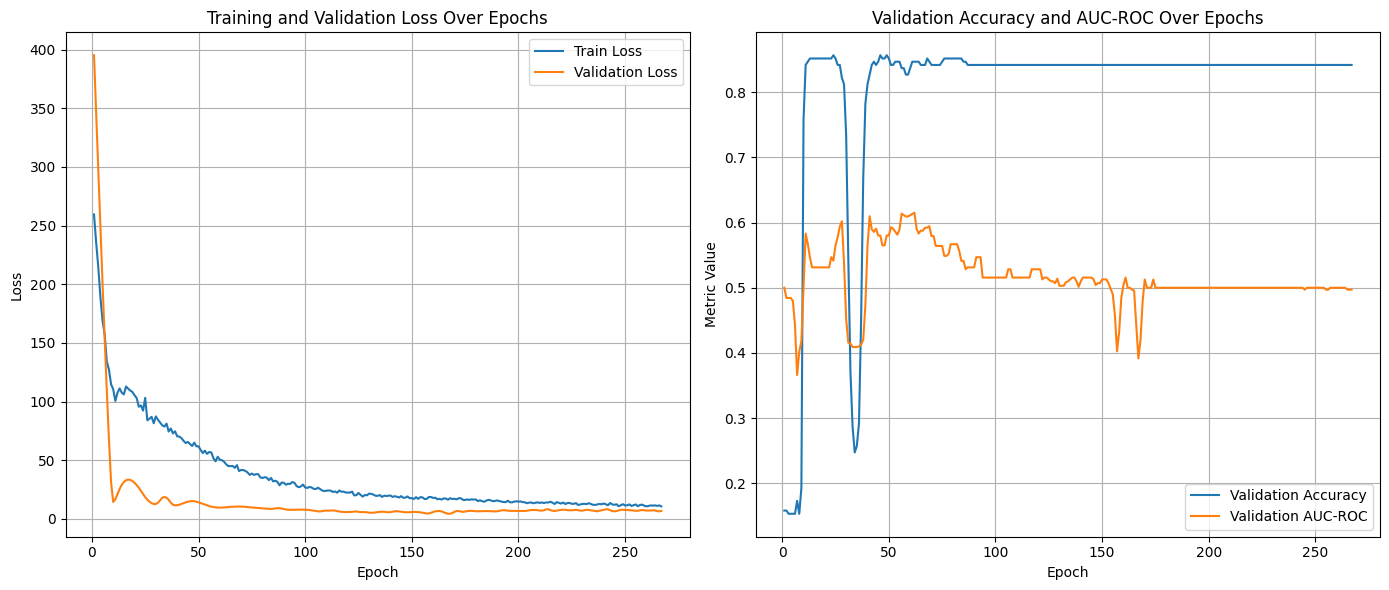

In [112]:
# Load the best model before final evaluation
model.load_state_dict(torch.load('best_link_prediction_model.pt'))
print("Loaded best model for final test evaluation.")

# Evaluation on Test Set
print("\n Evaluating on Test Set")
test_loss, test_acc, test_auc, test_predicted_labels, test_probabilities, test_true_labels, test_evaluated_edge_indices_global, test_derived_lineage_labels = evaluate_link_prediction(
        model, test_loader, criterion, device,
        neg_sample_ratio=1.0, radius_threshold=my_radius_threshold, node_lineage_map = node_lineage_dict
)
print(f"Final Test Results: Loss: {test_loss:.4f}, Accuracy: {test_acc:.4f}, AUC-ROC: {test_auc:.4f}")

# Plotting the Results
epochs_range = range(1, len(train_losses) + 1) 

plt.figure(figsize=(14, 6)) 

# Plotting Loss
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label='Train Loss')
plt.plot(epochs_range, val_losses, label='Validation Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plotting Accuracy and AUC-ROC
plt.subplot(1, 2, 2)
plt.plot(epochs_range, val_accuracies, label='Validation Accuracy')
plt.plot(epochs_range, val_aucs, label='Validation AUC-ROC')
plt.title('Validation Accuracy and AUC-ROC Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Metric Value')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [113]:
# Now you have the individual predictions!
print("\n--- Example Individual Predictions from Test Set ---")
print("Edge (Source, Dest) | Predicted Prob | Predicted Label | True Label")
print("-" * 60)
num_display = min(test_evaluated_edge_indices_global.size(1), 10)
for i in range(num_display):
    src, dst = test_evaluated_edge_indices_global[0, i].item(), test_evaluated_edge_indices_global[1, i].item()
    prob = test_probabilities[i].item()
    pred_label = test_predicted_labels[i].item()
    true_label = test_true_labels[i].item()
    print(f"({src:4d}, {dst:4d})          | {prob:.4f}           | {pred_label}             | {true_label}")

# You can then filter these results as needed:
# Find correctly predicted positive links
correct_pos_mask = (test_predicted_labels == 1) & (test_true_labels == 1)
correctly_predicted_pos_edges = test_evaluated_edge_indices_global[:, correct_pos_mask]
print(f"\nNumber of correctly predicted positive links: {correctly_predicted_pos_edges.size(1)}")
if correctly_predicted_pos_edges.size(1) > 0:
    print("Example correct positive predictions (first 5):", correctly_predicted_pos_edges[:, :5].T.tolist())

# Find false positives (predicted 1, but true is 0)
false_pos_mask = (test_predicted_labels == 1) & (test_true_labels == 0)
false_positive_edges = test_evaluated_edge_indices_global[:, false_pos_mask]
print(f"Number of false positive links: {false_positive_edges.size(1)}")
if false_positive_edges.size(1) > 0:
    print("Example false positive predictions (first 5):", false_positive_edges[:, :5].T.tolist())

# And so on for false negatives, true negatives, etc.


--- Example Individual Predictions from Test Set ---
Edge (Source, Dest) | Predicted Prob | Predicted Label | True Label
------------------------------------------------------------
( 158,  143)          | 1.0000           | 1             | 1.0
(  84,   66)          | 1.0000           | 1             | 1.0
(  59,   47)          | 1.0000           | 1             | 1.0
( 121,  102)          | 1.0000           | 1             | 1.0
(  34,   12)          | 1.0000           | 1             | 1.0
(  66,   59)          | 1.0000           | 1             | 1.0
(  47,   34)          | 1.0000           | 1             | 1.0
(  12,    5)          | 1.0000           | 1             | 1.0
( 102,   84)          | 1.0000           | 1             | 1.0
( 132,  121)          | 1.0000           | 1             | 1.0

Number of correctly predicted positive links: 340
Example correct positive predictions (first 5): [[158, 143], [84, 66], [59, 47], [121, 102], [34, 12]]
Number of false positive links: 3

In [116]:
# Convert tensors to lists for DataFrame construction
source_nodes = test_evaluated_edge_indices_global[0].tolist()
destination_nodes = test_evaluated_edge_indices_global[1].tolist()
predicted_probabilities = test_probabilities.tolist()
predicted_binary_labels = test_predicted_labels.tolist()
true_binary_labels = test_true_labels.tolist()
derived_lineage_labels = test_derived_lineage_labels

data_for_df = {
    'Source_Node': source_nodes,
    'Destination_Node': destination_nodes,
    'Predicted_Probability': predicted_probabilities,
    'Predicted_Label': predicted_binary_labels,
    'True_Label': true_binary_labels,
    'Derived_lineage': derived_lineage_labels
}

In [117]:
df_predictions = pd.DataFrame(data_for_df)

In [118]:
df_predictions

,Source_Node,Destination_Node,Predicted_Probability,Predicted_Label,True_Label,Derived_lineage
0,158,143,1.000000e+00,1,1.0,POS_(A.1.1.2_to_A.1.1.2)
1,84,66,1.000000e+00,1,1.0,POS_(A.1.1.2_to_A.1.1.2)
2,59,47,1.000000e+00,1,1.0,POS_(A.1.1.2_to_A.1.1.2)
3,121,102,1.000000e+00,1,1.0,POS_(A.1.1.2_to_A.1.1.2)
4,34,12,1.000000e+00,1,1.0,POS_(A.1.1.2_to_A.1.1.2)
...,...,...,...,...,...,...
677,158,98,1.000000e+00,1,0.0,NEG_(A.1.1.2_to_A.1.1.1)
678,208,183,1.000000e+00,1,0.0,NEG_(A.2.2.2.2.2.2.2.2_to_A.2.2.2.2.2.2.2.2)
679,223,219,1.000000e+00,1,0.0,NEG_(A.2.2.2.2.2.2.2.2.2_to_A.2.2.2.2.2.2.2.2.2)
680,500,433,3.895541e-23,0,0.0,NEG_(A.2.2.2.2_to_A.2.2.2.1)


In [119]:
# Create a dictionary connecting ground truth lineages to spec nodes and timeframes
lineage_node_dict = {}

for index, row in df_cells.iterrows():
    lineage = row['ground_truth_lineage']
    node_id = row['node_id']
    time_frame = row['time_frame']

    if lineage not in lineage_node_dict:
        lineage_node_dict[lineage] = {}

    lineage_node_dict[lineage][node_id] = time_frame